In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import chain
import scipy.stats as stats
from PLAB.utils import gini_coefficient

Load all data from both replicates.

In [2]:
file_sample_names = ['liquid', 'semisolid', 'small_spread','large_spread', 'bead']
names_dict = {'liquid': 'liquid', 'semisolid': 'semisolid', 'small_spread': 'high density spread', 'bead': 'bead spread', 'large_spread': 'low density spread'}
sample_names = [names_dict[name] for name in file_sample_names]
counts = []

for sample in file_sample_names:
    for replicate in ['1', '2']:
        with open(f'../../data/20221211_counts/{sample}_{replicate}.pkl', 'rb') as f:
            clusters = pickle.load(f)
            for center in clusters:
                counts.append((names_dict[sample], replicate, center, clusters[center].total()))

df = pd.DataFrame(counts, columns=['sample', 'rep', 'sequence', 'count'])

In [3]:
df.head()

,sample,rep,sequence,count
0,liquid,1,TTGTGTCTTGCATTGGCCGTGATTCTTCATTACAATTTGGATAACG...,84
1,liquid,1,TGTGCGCAATGTTCGGGGGGGGAGGCAGCGTATGAGTCGGTGCCAT...,83
2,liquid,1,CATTCCTTGCGCGGTAATAATTTTGTGCTTAAGATGTTCTTTGGCA...,81
3,liquid,1,AACCTCAGCGGATTGATGGCTAGTCCGTGTCTCATGTTCAAAGGGC...,80
4,liquid,1,CAAGAGGTTTAATATCTACTTTCATTTCGCTGCGCTTAAAAGATGA...,80


Compute sample statistics without any normalization.

In [4]:
sample_stats = []
for rep in ['1', '2']:
    for sample in sample_names:
        sample_counts = df.loc[(df['rep'] == rep) & (df['sample'] == sample)]['count']
        nobs, minmax, mean, var, skew, kurtosis = stats.describe(sample_counts)
        reads = sample_counts.sum()
        gini = gini_coefficient(np.array(sample_counts))
        median = np.median(sample_counts)
        stdev = np.std(sample_counts)
        sample_stats.append((sample, rep, nobs, reads, minmax[1], mean, median, stdev, skew, kurtosis, gini))
sample_stats_df = pd.DataFrame(sample_stats, columns=['sample', 'rep', 'unique seqs', 'reads', 'max', 'mean', 'median', 'stdev', 'skew', 'kurtosis', 'gini'])
sample_stats_df

,sample,rep,unique seqs,reads,max,mean,median,stdev,skew,kurtosis,gini
0,liquid,1,149911,2006745,84,13.386243,12.0,8.897498,1.030118,1.491881,0.363497
1,semisolid,1,159037,2001264,4307,12.583638,11.0,23.044295,64.350443,8804.278536,0.390812
2,high density spread,1,152552,2005883,677,13.148848,7.0,24.697384,9.223331,127.032316,0.567081
3,low density spread,1,140788,2005783,201,14.246832,10.0,14.099264,2.419991,9.764334,0.478795
4,bead spread,1,90034,2008530,174,22.308572,18.0,18.654192,1.286808,1.980816,0.447018
5,liquid,2,185519,4761021,164,25.663253,23.0,17.313532,0.985713,1.306862,0.370059
6,semisolid,2,197661,4773641,2377,24.150647,22.0,23.016580,23.278947,1479.530533,0.357412
7,high density spread,2,196799,4788545,341,24.332161,18.0,23.362758,2.432763,10.780857,0.468995
8,low density spread,2,195654,4785740,207,24.460221,20.0,18.735062,1.346400,2.506578,0.408097
9,bead spread,2,115312,4764943,371,41.322178,28.0,41.029724,1.645857,3.335567,0.509528


Normalize number of unique sequences to sample with highest count within each replicate (liquid culture for both replicates)

In [5]:
rep1_mask = sample_stats_df['rep'] == '1'
rep2_mask = sample_stats_df['rep'] == '2'
sample_stats_df['rel unique seqs'] = 0
sample_stats_df.loc[rep1_mask, 'rel unique seqs'] = sample_stats_df[rep1_mask]['unique seqs'] / sample_stats_df[rep1_mask]['unique seqs'].max()
sample_stats_df.loc[rep2_mask, 'rel unique seqs'] = sample_stats_df[rep2_mask]['unique seqs'] / sample_stats_df[rep2_mask]['unique seqs'].max()
sample_stats_df

,sample,rep,unique seqs,reads,max,mean,median,stdev,skew,kurtosis,gini,rel unique seqs
0,liquid,1,149911,2006745,84,13.386243,12.0,8.897498,1.030118,1.491881,0.363497,0.942617
1,semisolid,1,159037,2001264,4307,12.583638,11.0,23.044295,64.350443,8804.278536,0.390812,1.000000
2,high density spread,1,152552,2005883,677,13.148848,7.0,24.697384,9.223331,127.032316,0.567081,0.959223
3,low density spread,1,140788,2005783,201,14.246832,10.0,14.099264,2.419991,9.764334,0.478795,0.885253
4,bead spread,1,90034,2008530,174,22.308572,18.0,18.654192,1.286808,1.980816,0.447018,0.566120
5,liquid,2,185519,4761021,164,25.663253,23.0,17.313532,0.985713,1.306862,0.370059,0.938572
6,semisolid,2,197661,4773641,2377,24.150647,22.0,23.016580,23.278947,1479.530533,0.357412,1.000000
7,high density spread,2,196799,4788545,341,24.332161,18.0,23.362758,2.432763,10.780857,0.468995,0.995639
8,low density spread,2,195654,4785740,207,24.460221,20.0,18.735062,1.346400,2.506578,0.408097,0.989846
9,bead spread,2,115312,4764943,371,41.322178,28.0,41.029724,1.645857,3.335567,0.509528,0.583383


In [6]:
sample_stats_df_long = sample_stats_df.melt(id_vars=['sample', 'rep'])
sample_stats_df_long.to_pickle('sample_stats.pkl')
sample_stats_df_long.head()

,sample,rep,variable,value
0,liquid,1,unique seqs,149911.0
1,semisolid,1,unique seqs,159037.0
2,high density spread,1,unique seqs,152552.0
3,low density spread,1,unique seqs,140788.0
4,bead spread,1,unique seqs,90034.0


In [70]:
sns.color_palette()[1]

(1.0, 0.4980392156862745, 0.054901960784313725)

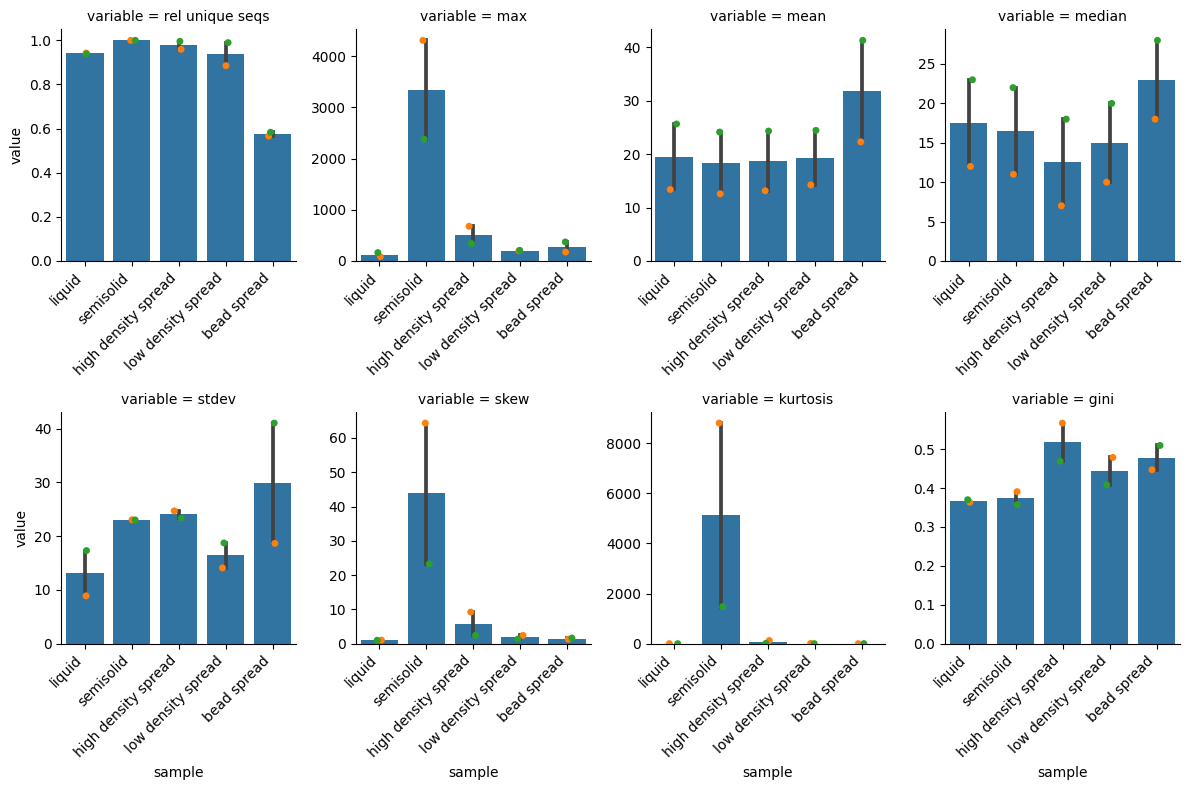

In [72]:
g = sns.FacetGrid(sample_stats_df_long, col='variable',
                  col_order=['rel unique seqs', 'max', 'mean', 'median', 'stdev', 'skew', 'kurtosis', 'gini'],
                  col_wrap=4, height=4, aspect=0.75, sharex=False, sharey=False)
g.map(sns.barplot, 'sample', 'value', order=sample_names)
g.map(sns.stripplot, 'sample', 'value', 'rep', order=sample_names, hue_order=['1', '2'], palette=sns.color_palette()[1:3])
for axes in g.axes.flat:
    _ = axes.set_xticklabels(axes.get_xticklabels(), rotation=45, ha='right')
plt.tight_layout()
plt.savefig("images/stats.svg")
plt.show()

In [8]:
print(sample_stats_df_long[(sample_stats_df_long['variable'] == 'gini') & (sample_stats_df_long['sample'] == 'liquid')]['value'])
print(sample_stats_df_long[(sample_stats_df_long['variable'] == 'gini') & (sample_stats_df_long['sample'] == 'high density spread')]['value'])

80    0.363497
85    0.370059
Name: value, dtype: float64
82    0.567081
87    0.468995
Name: value, dtype: float64


In [9]:
res = stats.ttest_ind(sample_stats_df_long[(sample_stats_df_long['variable'] == 'gini') & (sample_stats_df_long['sample'] == 'liquid')]['value'], 
                sample_stats_df_long[(sample_stats_df_long['variable'] == 'gini') & (sample_stats_df_long['sample'] == 'high density spread')]['value'],
                equal_var = False)

res.pvalue

0.1982396263943014

In [10]:
stats.ttest_rel(sample_stats_df_long[(sample_stats_df_long['variable'] == 'gini') & (sample_stats_df_long['sample'] == 'liquid')]['value'], 
                sample_stats_df_long[(sample_stats_df_long['variable'] == 'gini') & (sample_stats_df_long['sample'] == 'high density spread')]['value'])

Ttest_relResult(statistic=-2.890817862086384, pvalue=0.2120185893947956)

Normalize sequence count

In [11]:
colors = ["#E69F00", "#56B4E9", "#009E73", "#0072B2", "#D55E00"]
sns.set_palette(sns.color_palette(colors))

In [12]:
# sample_stats_df.to_csv("stats.csv")

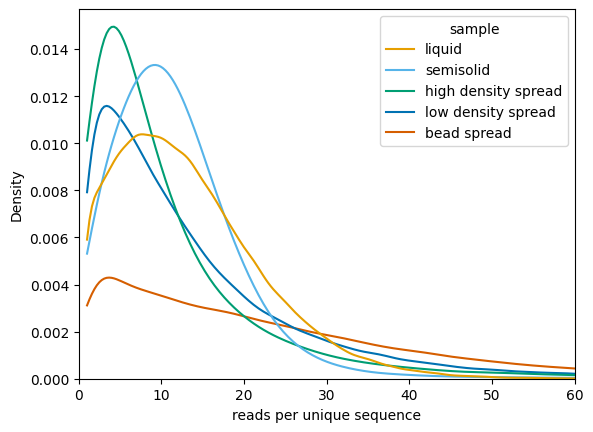

In [13]:
sns.kdeplot(data=df.loc[df['rep'] == '1'], x='count', hue='sample', clip=[1,60])
plt.xlim([0,60])
plt.xlabel("reads per unique sequence")
plt.savefig("images/rep1_kde.svg")

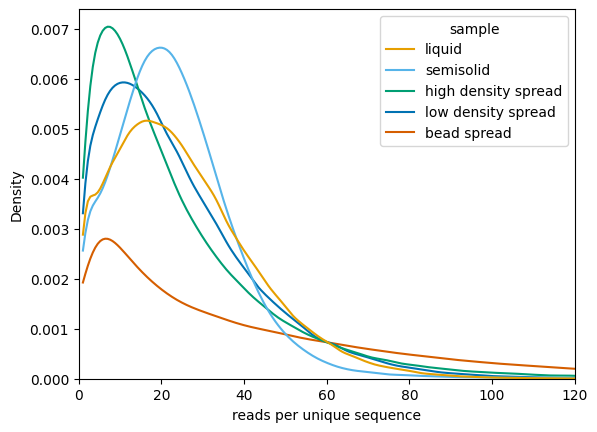

In [14]:
sns.kdeplot(data=df.loc[df['rep'] == '2'], x='count', hue='sample', clip=[1,120])
plt.xlim([0,120])
plt.xlabel("reads per unique sequence")
plt.savefig("images/rep2_kde.svg")

In [64]:
good = np.random.normal(loc=30.0, scale=1, size=100000)
bad = np.random.normal(loc=30.0, scale=5.0, size=100000)

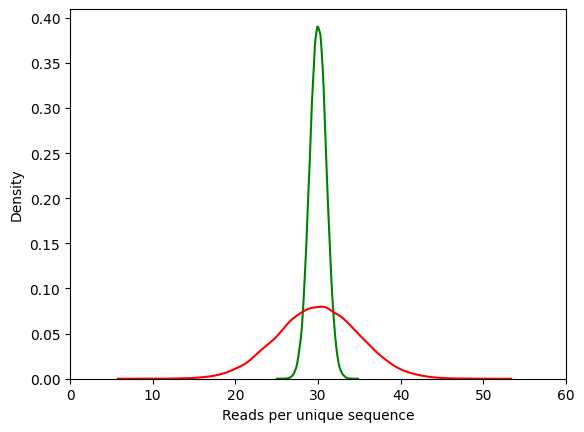

In [69]:
sns.kdeplot(x=good, color='green')
sns.kdeplot(x=bad, color='red')
plt.xlim([0,60])
plt.xlabel("Reads per unique sequence")
plt.savefig("images/example.svg")
plt.show()

In [15]:
df['log10_count'] = np.log10(df['count'])

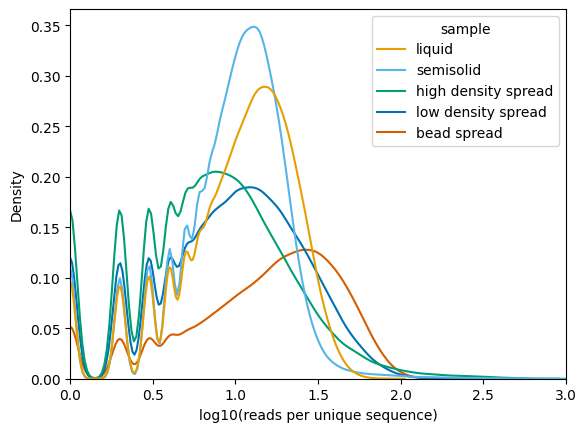

<Figure size 640x480 with 0 Axes>

In [16]:
sns.kdeplot(data=df.loc[df['rep'] == '1'], x='log10_count', hue='sample', clip=[0,3])
plt.xlim([0,3])
plt.xlabel("log10(reads per unique sequence)")
plt.show()
plt.savefig("images/rep1_kde_log.svg")

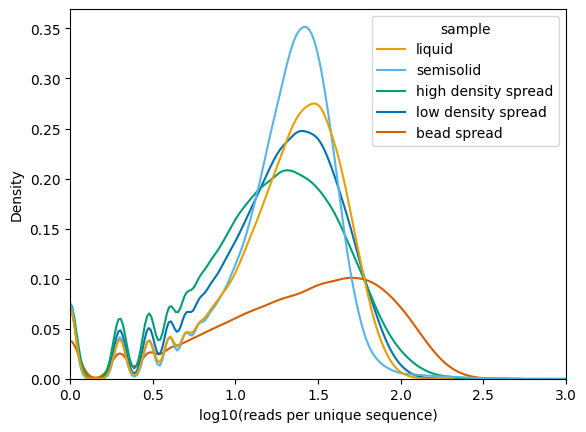

<Figure size 640x480 with 0 Axes>

In [17]:
sns.kdeplot(data=df.loc[df['rep'] == '2'], x='log10_count', hue='sample', clip=[0,3])
plt.xlim([0,3])
plt.xlabel("log10(reads per unique sequence)")
plt.show()
plt.savefig("images/rep2_kde_log.svg")

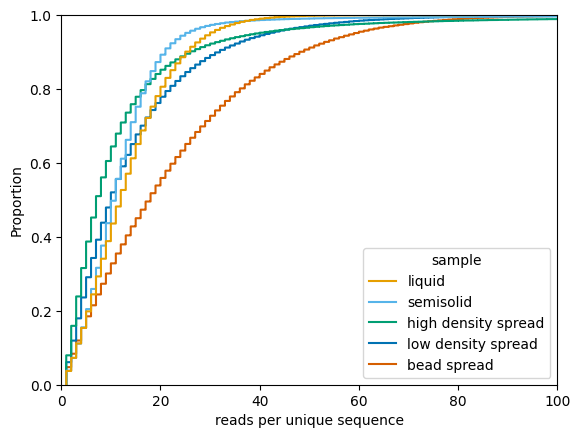

In [18]:
sns.ecdfplot(data=df.loc[df['rep'] == '1'], x='count', hue='sample')
plt.xlim([0,100])
plt.xlabel("reads per unique sequence")
plt.savefig("images/rep1_cdf.svg")

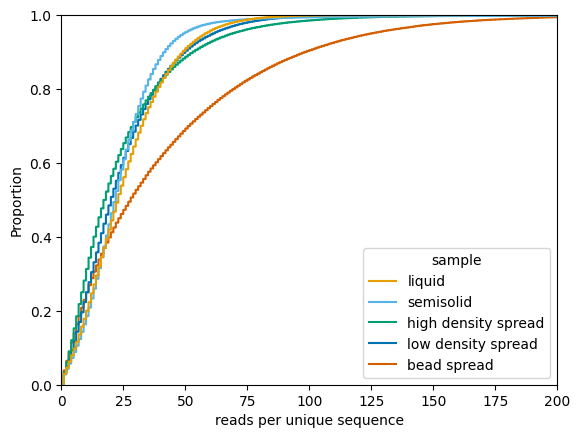

In [19]:
sns.ecdfplot(data=df.loc[df['rep'] == '2'], x='count', hue='sample')
plt.xlim([0,200])
plt.xlabel("reads per unique sequence")
plt.savefig("images/rep2_cdf.svg")

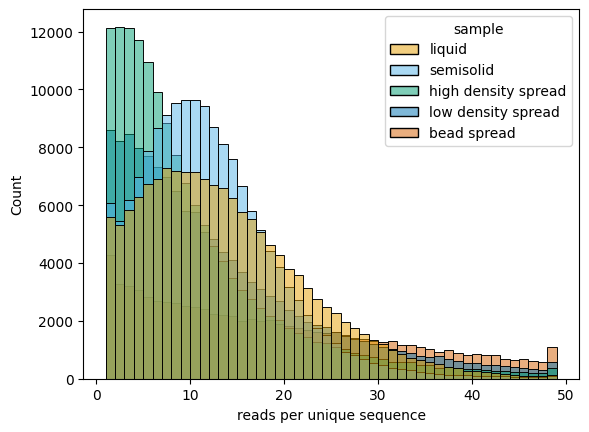

In [20]:
sns.histplot(data=df.loc[df['rep'] == '1'], x='count', hue='sample', bins=range(1,50))
plt.xlabel("reads per unique sequence")
plt.savefig("images/rep1_hist.svg")

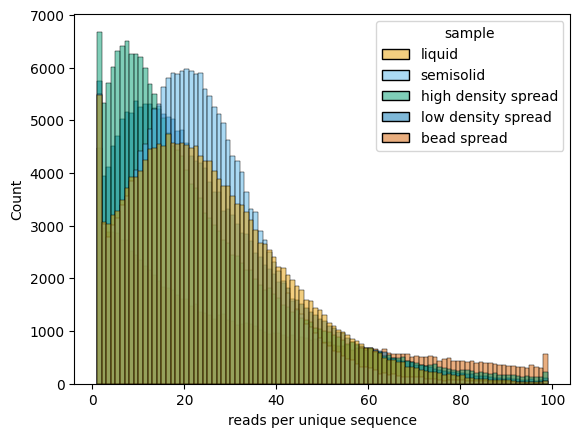

In [21]:
sns.histplot(data=df.loc[df['rep'] == '2'], x='count', hue='sample', bins=range(1,100))
plt.xlabel("reads per unique sequence")
plt.savefig("images/rep2_hist.svg")

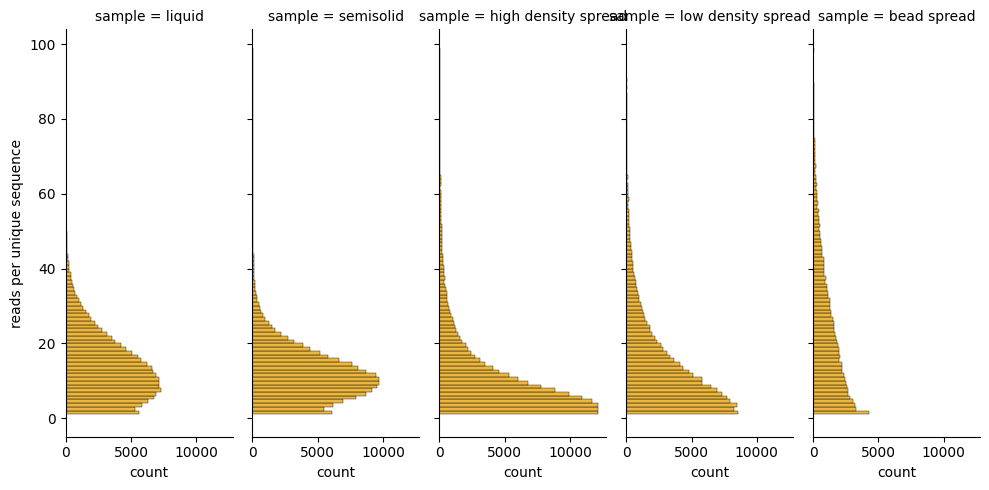

In [22]:
g = sns.displot(data=df.loc[df['rep'] == '1'], y='count', col='sample', aspect=.4, bins=range(100))
g.set_axis_labels("count", "reads per unique sequence")
g.savefig("images/rep1_displot.svg")

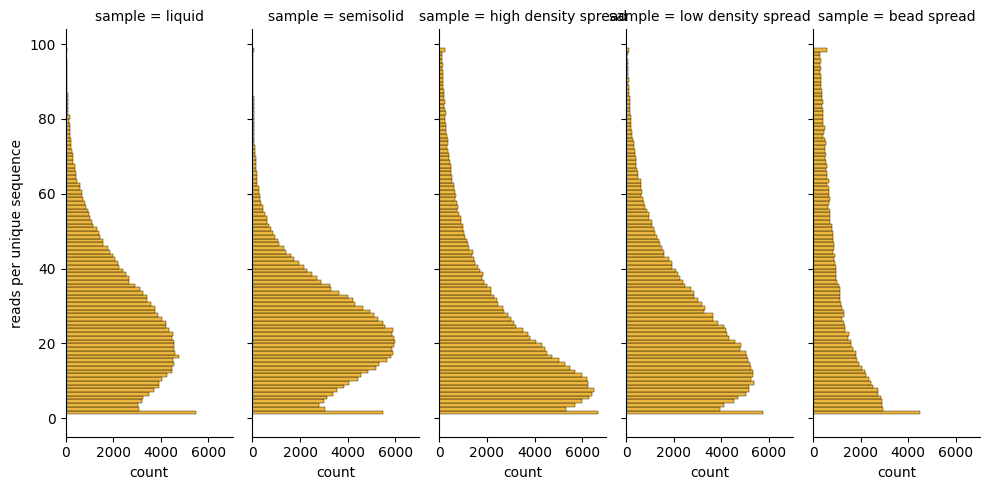

In [23]:
g = sns.displot(data=df.loc[df['rep'] == '2'], y='count', col='sample', aspect=.4, bins=range(100))
g.set_axis_labels("count", "reads per unique sequence")
g.savefig("images/rep1_displot.svg")

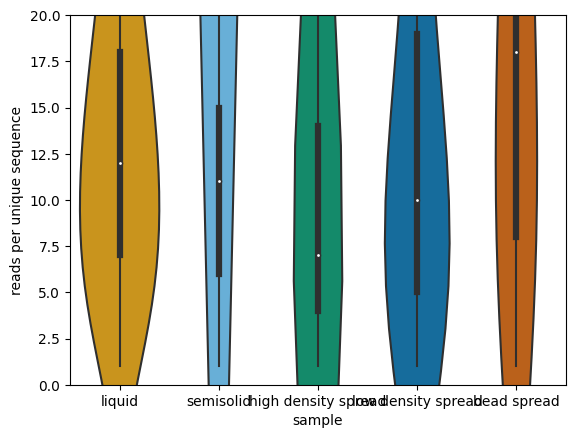

In [24]:
sns.violinplot(data=df.loc[df['rep'] == '1'], y='count', x='sample', bw=0.5)
plt.ylim([0,20])
plt.ylabel("reads per unique sequence")
plt.savefig("images/rep1_violin.svg")

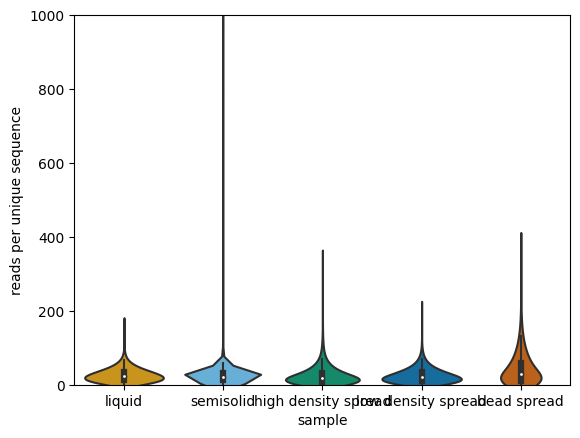

In [25]:
sns.violinplot(data=df.loc[df['rep'] == '2'], y='count', x='sample', bw=0.5)
plt.ylim([0,1000])
plt.ylabel("reads per unique sequence")
plt.savefig("images/rep2_violin.svg")

C:\Users\nmateyko\AppData\Local\Temp\ipykernel_21748\704730269.py:7: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim([0,4000])


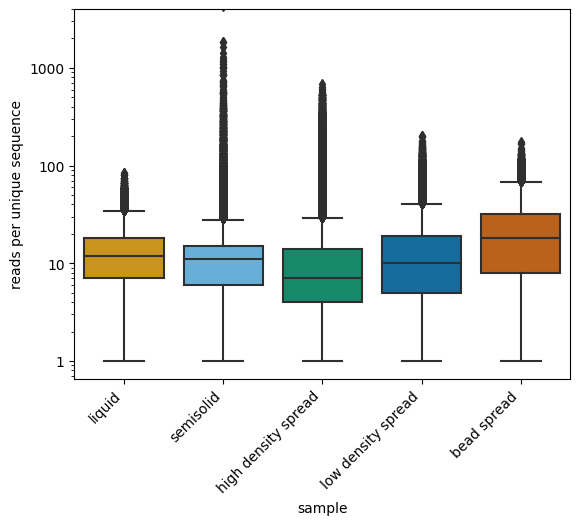

In [26]:
g = sns.boxplot(data=df.loc[df['rep'] == '1'], y='count', x='sample')
g.set_yscale("log")
ticks = [1, 10, 100, 1000]
g.set_yticks(ticks)
g.set_yticklabels(ticks)
plt.xticks(rotation=45, ha='right')
plt.ylim([0,4000])
plt.ylabel("reads per unique sequence")
plt.savefig("images/rep1_box.svg")
plt.show()

C:\Users\nmateyko\AppData\Local\Temp\ipykernel_21748\2899463886.py:7: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim([0,4000])


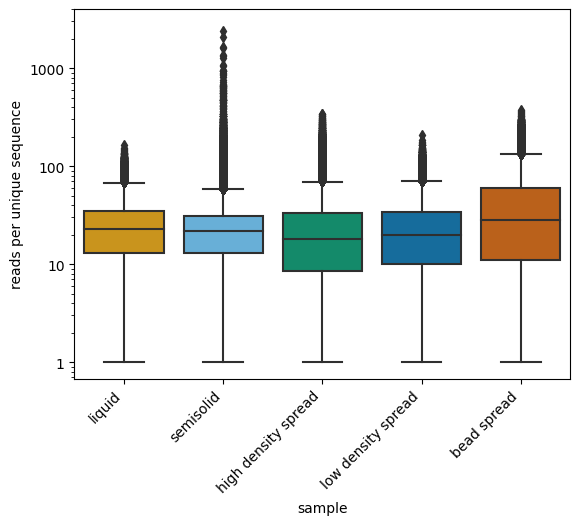

In [27]:
g = sns.boxplot(data=df.loc[df['rep'] == '2'], y='count', x='sample')
g.set_yscale("log")
ticks = [1, 10, 100, 1000]
g.set_yticks(ticks)
g.set_yticklabels(ticks)
plt.xticks(rotation=45, ha='right')
plt.ylim([0,4000])
plt.ylabel("reads per unique sequence")
plt.savefig("images/rep2_box.svg")
plt.show()

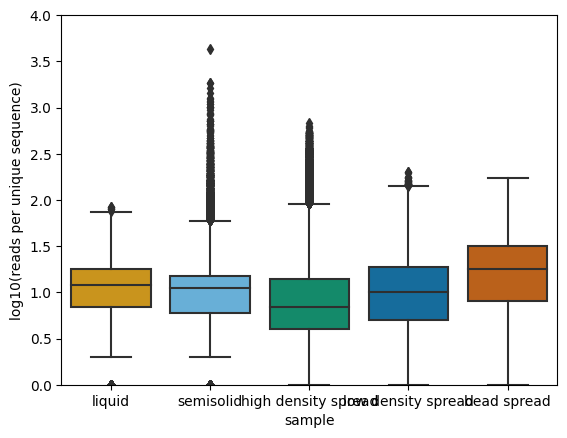

In [28]:
sns.boxplot(data=df.loc[df['rep'] == '1'], y='log10_count', x='sample')
plt.ylim([0,4])
plt.ylabel("log10(reads per unique sequence)")
plt.savefig("images/rep1_box.svg")

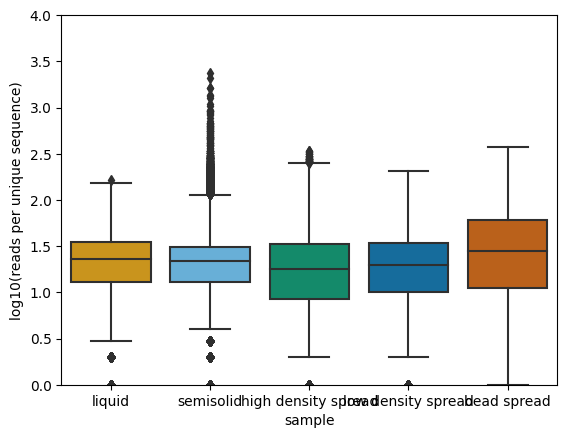

In [29]:
sns.boxplot(data=df.loc[df['rep'] == '2'], y='log10_count', x='sample')
plt.ylim([0,4])
plt.ylabel("log10(reads per unique sequence)")
plt.savefig("images/rep2_box.svg")

In [30]:
def label(x, color, label):
  ax = plt.gca()
  ax.text(0.3, 0.4, label, fontweight="bold", color=color,
      ha="left", va="center", transform=ax.transAxes)

def plot_ridge(df, max, name):
  sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})

  # Initialize the FacetGrid object
  pal = sns.cubehelix_palette(10, rot=-.25, light=.7)
  g = sns.FacetGrid(df, row="sample", hue="sample", aspect=5, height=1, palette=pal)

  # Draw the densities in a few steps
  g.map(sns.kdeplot, "count",
    bw_adjust=.5, clip=[1, max],
    fill=True, alpha=1, linewidth=1.5, cut=1)
  plt.xlim([0,max])
  g.map(sns.kdeplot, "count", clip_on=False, color="w", lw=2, bw_adjust=.5, clip=[1, max], cut=1)

  # passing color=None to refline() uses the hue mapping
  g.refline(y=0, linewidth=2, linestyle="-", color=None, clip_on=False)

  g.map(label, "count")

  # Set the subplots to overlap
  g.figure.subplots_adjust(hspace=-.4)

  # Remove axes details that don't play well with overlap
  g.set_titles("")
  g.set(yticks=[], ylabel="", xlabel="reads per unique sequence")
  g.despine(bottom=True, left=True)
  # plt.savefig(f"../../images/{name}.svg")

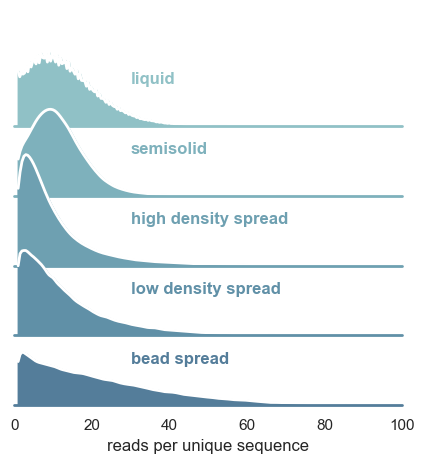

In [31]:
plot_ridge(df.loc[df['rep'] == '1'], 100, 'kde_stack_rep1')
plt.savefig("images/rep1_ridge.svg")

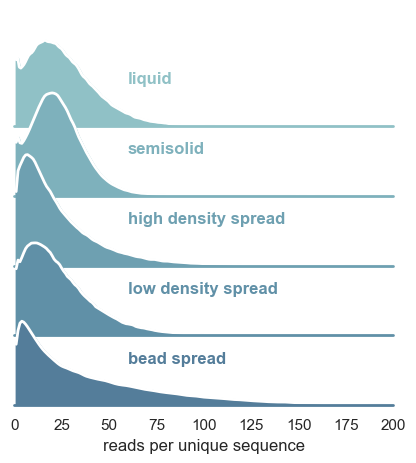

In [32]:
plot_ridge(df.loc[df['rep'] == '2'], 200, 'kde_stack_rep2')
plt.savefig("images/rep2_ridge.svg")

In [33]:
sns.reset_defaults()

The semisolid samples have some extreme outliers with very high counts. Check what the sequences of these outliers are to make sure they're not something weird (e.g. all G).

In [34]:
df.loc[df['sample'] == 'semisolid'].head()

,sample,rep,sequence,count,log10_count
335430,semisolid,1,GTGAAGGAGGCATGGGTATATATGTGCGGGAGGCTGATGAGTACCG...,4307,3.634175
335431,semisolid,1,TATCGTCTGTGGTTTATTAGATCTGGGGATTACGACTTACTAGCAC...,1828,3.261976
335432,semisolid,1,TCGACAAGTCTTTGCCTTTTCTAATGAGCCCTTAGATTTGTTTCCA...,1822,3.260548
335433,semisolid,1,GGAGGGAGTACCATTGCTGTTCTGTTATGGCGACCATAGCGTATAT...,1622,3.210051
335434,semisolid,1,CTTCATCGGATACGGCTGACCACAACAATAGTCTTTGAAGTGTTCT...,1431,3.155640


In [35]:
print(df.loc[df['sample'] == 'semisolid'].reset_index().at[0, 'sequence'])
print(df.loc[df['sample'] == 'semisolid'].reset_index().at[1, 'sequence'])

GTGAAGGAGGCATGGGTATATATGTGCGGGAGGCTGATGAGTACCGTGCCATTTACGAGTGGTGAGACAGGAGGGGAGGG
TATCGTCTGTGGTTTATTAGATCTGGGGATTACGACTTACTAGCACCCTTGTGAGGTGATTATTTTCTTTATCTCTCTTC


In [36]:
df.loc[(df['sample'] == 'semisolid') & (df['rep'] == '2')].head()

,sample,rep,sequence,count,log10_count
494467,semisolid,2,TCCGCGACAAAAGCTATTTCTTTTCCCTCAAGAATTGCATATATAT...,2377,3.376029
494468,semisolid,2,TTTGTTTCGTTTTTGCGTCTATCGTCGGGGCTGGTCCGGAGCGTGC...,2081,3.318272
494469,semisolid,2,TGGCCACATGTTCCGGGCCCTACTTTTAGGTTCCTAAAATTATCAG...,1639,3.214579
494470,semisolid,2,TTTATTCCGGGTTTTCAAACGCGCGGGGTGTACTTCCCTCTTGTTC...,1621,3.209783
494471,semisolid,2,TTTTATGACCTTTGATTCGATGGTCACATAAGCATGCTCAGGCTAC...,1352,3.130977


In [37]:
print(df.loc[(df['sample'] == 'semisolid') & (df['rep'] == '2')].reset_index().at[0, 'sequence'])
print(df.loc[(df['sample'] == 'semisolid') & (df['rep'] == '2')].reset_index().at[1, 'sequence'])

TCCGCGACAAAAGCTATTTCTTTTCCCTCAAGAATTGCATATATATAGGTTTATTGCGGGGACCAAGTCTCCAGGTGGGA
TTTGTTTCGTTTTTGCGTCTATCGTCGGGGCTGGTCCGGAGCGTGCTACGGCTTATCAGGATGTACGCGGCATAAGTTCG


There doesn't seem to be anything particularly strange about these sequences.

Often a minimum number of reads per unique sequence is required for assays where read counts are used to estimate sequence abundance. I'll plot the number of sequences that pass the threshold as a function of the threshold for the each sample to see which library amplification method gives the highest number of usable sequences at each threshold.

In [38]:
def calc_seqs_passing(sample_names, replicate, n):
    seqs_passing = dict((sample, []) for sample in sample_names)
    for sample in seqs_passing:
        for threshold in range(1, n):
            num_passed = df.loc[(df['sample'] == sample) & (df['rep'] == replicate) & (df['count'] >= threshold)].count().at['count']
            # print(num_passed, '\n')
            # print(threshold)
            seqs_passing[sample].append(num_passed)
    passed_df = pd.DataFrame.from_dict(seqs_passing)
    passed_df.index += 1
    return passed_df


In [39]:
passed_df = calc_seqs_passing(sample_names, '1', 31)
passed_df

# sns.lineplot(passed_df)
# plt.xlabel("threshold")
# plt.ylabel("unique sequences")
# plt.show()

,liquid,semisolid,high density spread,low density spread,bead spread
1,149911,159037,152552,140788,90034
2,144332,152978,140416,132197,85754
3,139021,147522,128247,123982,82484
4,133189,141339,116114,115510,79265
5,126895,134376,104397,107547,76186
6,120158,126491,93452,99838,73369
7,113260,117830,83545,92512,70686
8,105982,108720,74718,85541,68044
9,98807,99173,66975,79062,65437
10,91676,89523,60216,73279,62940


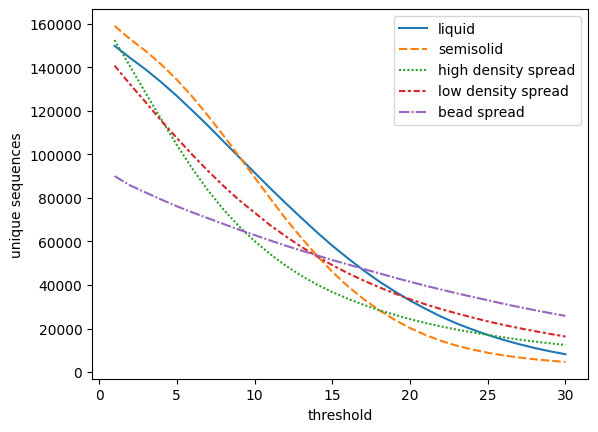

In [40]:
sns.lineplot(passed_df)
plt.xlabel("threshold")
plt.ylabel("unique sequences")
plt.show()

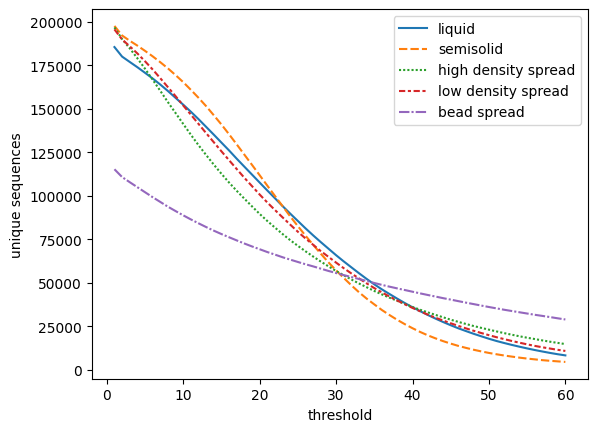

In [41]:
passed_df = calc_seqs_passing(sample_names, '2', 61)

sns.lineplot(passed_df)
plt.xlabel("threshold")
plt.ylabel("unique sequences")
plt.show()

The semisolid medium resulted in outlier sequences with very high abundances compared to the other culture conditions. I'll calculate the proportion of the total reads that the top n most abundant sequences take up for increasing n to see how much of a problem this is.

In [42]:
def calc_proportions(sample_names, replicate, n):
    proportions = dict((sample, []) for sample in sample_names)
    for sample in proportions:
            sample_counts = df.loc[(df['sample'] == sample) & (df['rep'] == replicate)]
            sample_counts = sample_counts.sort_values('count', ascending=False)
            total = sample_counts['count'].sum()
            for i in range(1, n + 1):
                n_highest = sample_counts.head(i)
                proportion_highest = n_highest['count'].sum() / total
                proportions[sample].append(proportion_highest)
                if i == 160:
                    print(proportion_highest)
    proportion_df = pd.DataFrame.from_dict(proportions)
    proportion_df.index += 1
    return proportion_df

0.004753967245464671
0.03910428609119037
0.03374025304566617
0.009999087638094449
0.009107655847809095


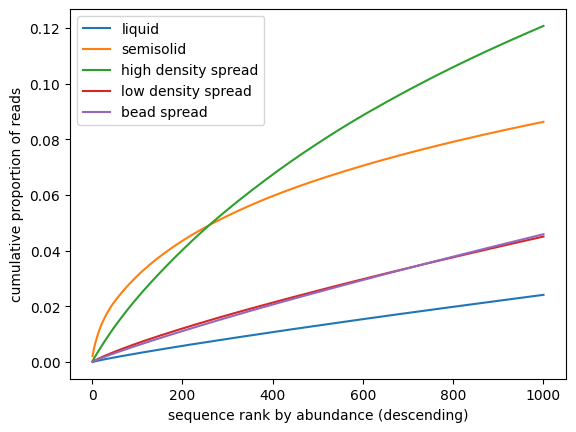

In [43]:
proportion_df = calc_proportions(sample_names, '1', 1000)
sns.lineplot(proportion_df, dashes=False)
plt.xlabel("sequence rank by abundance (descending)")
plt.ylabel("cumulative proportion of reads")
plt.savefig("images/rep1_proportion.svg")
plt.show()

0.0038657674477806337
0.015629788666554522
0.007689183248773897
0.004409140488200362
0.009037883559152754


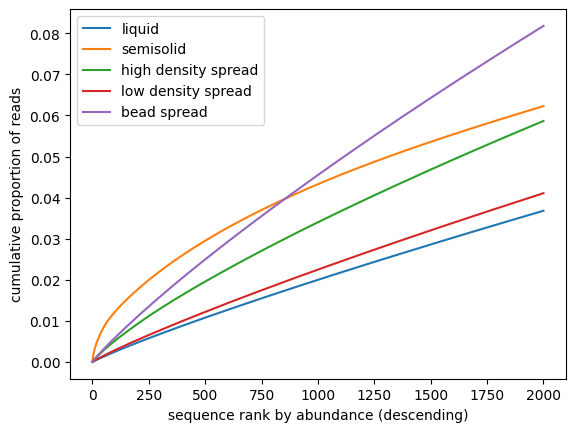

In [44]:
proportion_df = calc_proportions(sample_names, '2', 2000)
sns.lineplot(proportion_df, dashes=False)
plt.xlabel("sequence rank by abundance (descending)")
plt.ylabel("cumulative proportion of reads")
plt.savefig("images/rep2_proportion.svg")
plt.show()

In [45]:
def lorenz_curve(sample_names, replicate):
    proportions = dict((sample, []) for sample in sample_names)
    max_unique = df.loc[(df['rep'] == replicate)].groupby('sample')['sample'].count().max()
    print(max_unique)
    for sample in proportions:
            sample_counts = df.loc[(df['sample'] == sample) & (df['rep'] == replicate)]
            sample_counts = sample_counts.sort_values('count', ascending=True)
            total = sample_counts['count'].sum()
            sample_counts = list(sample_counts['count'])
            print(sample_counts[:10])
            read_sum = 0
            for i in range(max_unique):
                if i < len(sample_counts):
                    read_sum += sample_counts[i]
                proportion = read_sum / total
                proportions[sample].append(proportion)
    proportion_df = pd.DataFrame.from_dict(proportions)
    proportion_df.index += 1
    return proportion_df

159037
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


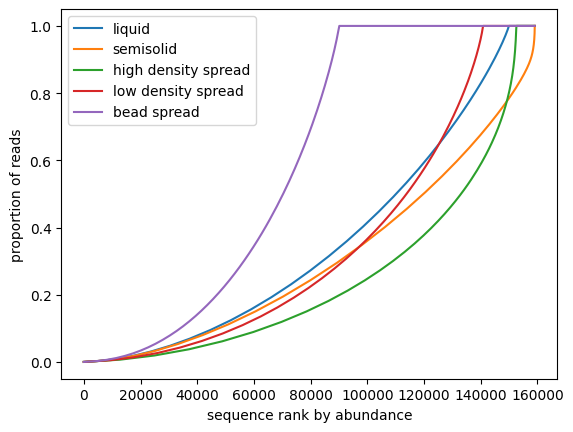

In [46]:
lorenz_df = lorenz_curve(sample_names, '1')
sns.lineplot(lorenz_df, dashes=False)
plt.xlabel("sequence rank by abundance")
plt.ylabel("proportion of reads")
plt.show()
plt.savefig("images/rep1_lorenz.svg")